# Deep Learning - 2024

Grupo: Carlos Carneiro e Liliana Alvelos

# Dependencies

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


import tensorflow_datasets as tfds # to import the dataset

# Auxiliary functions /code

This function takes in an iterator "this_iterator", which is expected to contain data items (such as images or batches) along with their corresponding labels. It counts the number of items in the iterator and prints out a message indicating the count of items in the dataset.


In [34]:
def count_n_images_iterator(this_iterator, name, what='images'):

    count_items = 0
    for item, label in this_iterator:
        count_items += 1

    print(f'The {name} dataset has {count_items} {what}.')

Function to plot training and validation accuracy/loss curves.

The function "plot_accuracy_loss(history)" is designed to visualize the training and validation accuracy as well as the training and validation loss over epochs during the training of a machine learning model.



In [35]:
def plot_acuracy_loss(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

#1. Load Data

##1.1. Data preparation

Split the 'train' dataset into three equal parts using TensorFlow Datasets (tfds)

In [36]:
split0, split1, split2 = tfds.even_splits('train', n=3)

Load the 'malaria' datasets (training, test and validation)

'split=splitx' indicates that we're loading the first split of the dataset

'shuffle_files=False' ensures that the files are not shuffled before loading

 'as_supervised=True' loads the data in a tuple format (input, label)

 'with_info=True' also loads metadata information about the dataset

In [37]:
ds_train, ds_info = tfds.load(
    'malaria',
    split=split0,
    shuffle_files=False,
    as_supervised=True,
    with_info=True,
    )

In [38]:
ds_test, __ = tfds.load(
    'malaria',
    split=split1,
    shuffle_files=False,
    as_supervised=True,
    with_info=True,
    )

In [39]:
ds_val, __ = tfds.load(
    'malaria',
    split=split2,
    shuffle_files=False,
    as_supervised=True,
    with_info=True,
    )

##1.2. Data information

Print metadata information about the dataset

In [40]:
print(ds_info)

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear im

Malaria is a dataset with 27.558 cell images where each data instance consists of an **image** of a cell, with variable shape and uint8 data type, and a corresponding **label**, represented as a 64-bit unsigned integer, with two classes, indicating whether the cell is parasitized or uninfected.
The cell images are represented as uint8 arrays with variable shapes.
The dataset has shuffling of the data disabled and the available dataset splits is only "train".

##1.3. Explore the data

Display example images from the dataset

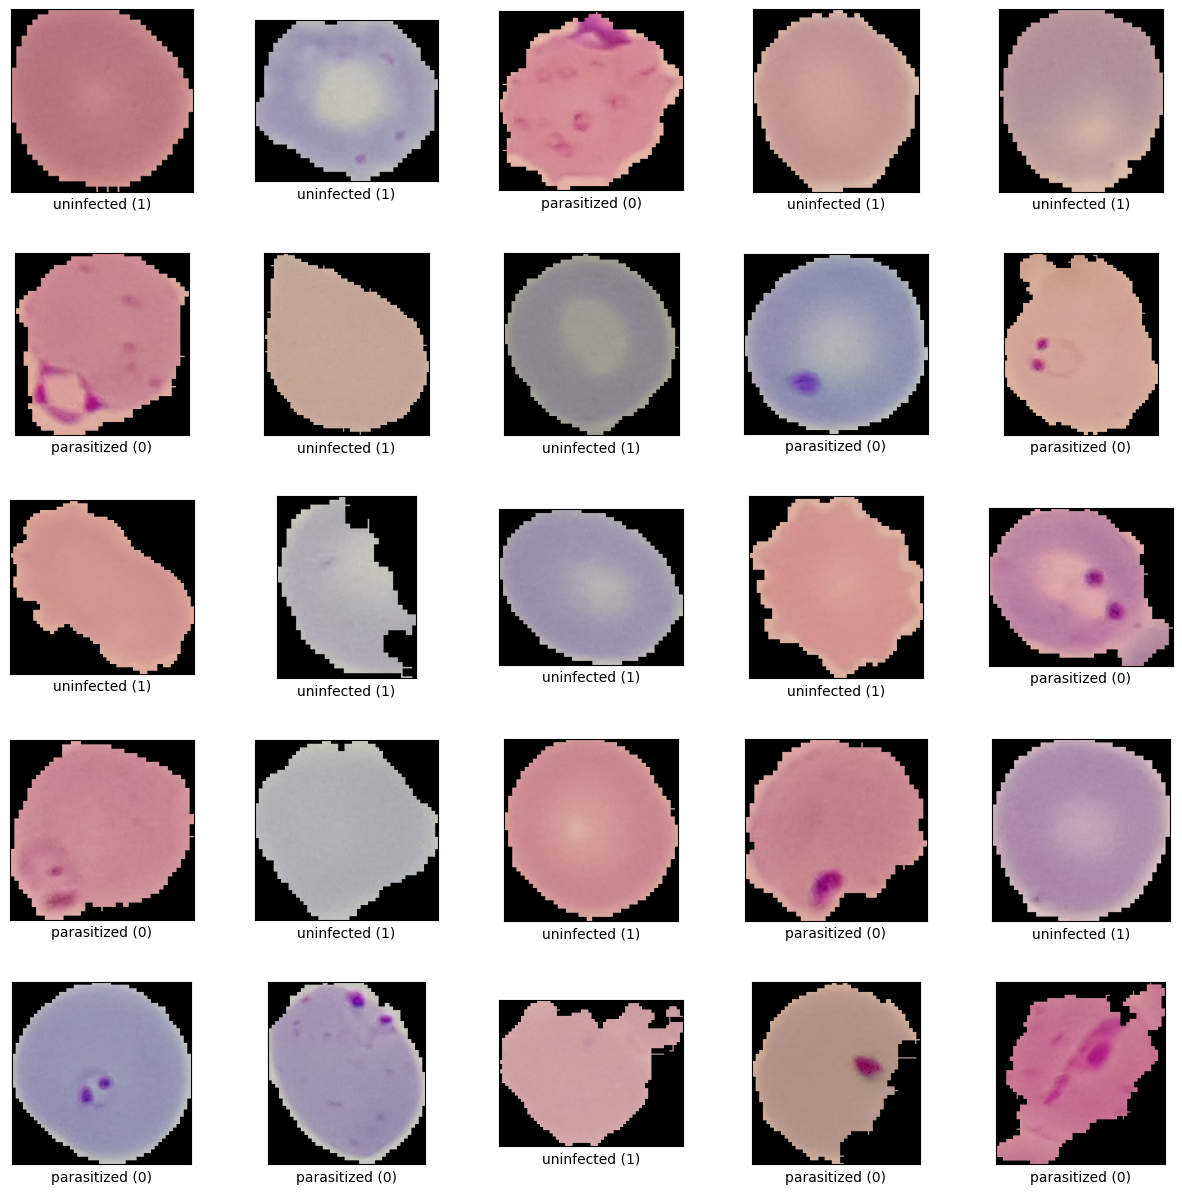

In [31]:
fig = tfds.show_examples(ds_train, ds_info, rows=5, cols=5)

In [32]:
count_n_images_iterator(ds_train, 'train'),
count_n_images_iterator(ds_test, 'test'),
count_n_images_iterator(ds_val, 'validation')

The train dataset has 9186 images.
The test dataset has 9186 images.
The validation dataset has 9186 images.


The dataset contains images that can have variable dimensions in terms of height and width, but they all have 3 channels. The 3 channels represent the red, green, and blue color channels of the image.

The dataset is relatively large, for the porpuse of speeding up experimentation a sub set of it is going to be selected.
By working with smaller subsets, it can iterate more quickly during the experimentation phase, testing different model architectures, hyperparameters, and preprocessing techniques in a more agile manner.

# 2. Transform Data

  ## 2.1. Create a sub sample



Creating subsets of the training, testing, and validation datasets to work with smaller samples

In [41]:
sub_ds_train = ds_train.take(1000)
sub_ds_test = ds_test.take(200)
sub_ds_val = ds_val.take(500)

In [42]:
count_n_images_iterator(sub_ds_train, 'train'),
count_n_images_iterator(sub_ds_test, 'test'),
count_n_images_iterator(sub_ds_val, 'validation')

The train dataset has 1000 images.
The test dataset has 200 images.
The validation dataset has 500 images.


  ## 2.2. Normalize data

Function to normalize the input image data.


In [43]:
def normalize_image(image, label):
    return tf.cast(image, tf.float32) /255.0, label

These lines of code apply the normalize_image function to each element of the sub_ds_train, sub_ds_test, and sub_ds_val datasets using the map function. This function essentially transforms each element of the dataset by applying the specified function (normalize_image in this case) to it. As a result, normalize_ds_train, normalize_ds_test, and normalize_ds_val contain the normalized versions of the original datasets sub_ds_train, sub_ds_test, and sub_ds_val, respectively.

In [44]:
normalize_ds_train = sub_ds_train.map(normalize_image)
normalize_ds_test = sub_ds_test.map(normalize_image)
normalize_ds_val = sub_ds_val.map(normalize_image)

  ## 2.3. Resize images

Defines a function that takes an image and its corresponding label as input parameters, along with optional parameters for the target height and width.

In [45]:
def resize_image(image, label, target_height=100, target_width=100):
    return tf.image.resize_with_pad(image, target_height, target_width), label

In [46]:
resized_ds_train = normalize_ds_train.map(resize_image)
resized_ds_test = normalize_ds_test.map(resize_image)
resized_ds_val = normalize_ds_val.map(resize_image)

In [ ]:
count_n_images_iterator(resized_ds_train, 'train'),
count_n_images_iterator(resized_ds_test, 'test'),
count_n_images_iterator(resized_ds_val, 'validation')

The train dataset has 1000 images.
The test dataset has 200 images.
The validation dataset has 500 images.


##2.4. Data after transformation

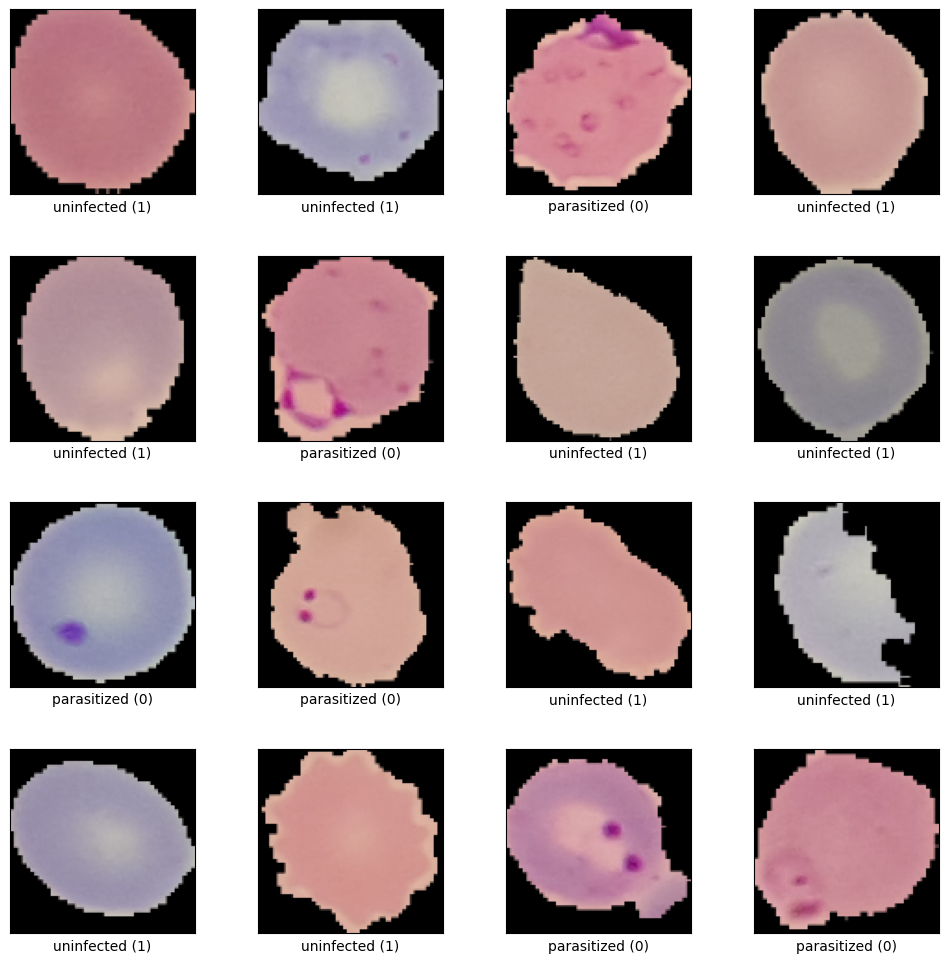

In [ ]:
fig = tfds.show_examples(resized_ds_train, ds_info, rows=4, cols=4)

##2.5. Define batch size

Segment batches the datasets datasets into batches of size 128. Batching is a common technique used in machine learning to process data in smaller chunks rather than individually, which can improve computational efficiency during training and evaluation. By batching the datasets, the model will process 128 images and their corresponding labels at a time during each training iteration, which can help speed up training and utilize parallel processing capabilities of hardware.

In [47]:
#resized_ds_train = resized_ds_train.batch(256) # depende da memoria disponiveis na maquina, numero maior representa mais dados em memoria
#resized_ds_test = resized_ds_test.batch(256) # depende da memoria disponiveis na maquina, numero maior representa mais dados em memoria
#resized_ds_val = resized_ds_val.batch(256) # depende da memoria disponiveis na maquina, numero maior representa mais dados em memoria

resized_ds_train = resized_ds_train.batch(128) # depende da memoria disponiveis na maquina, numero maior representa mais dados em memoria
resized_ds_test = resized_ds_test.batch(128) # depende da memoria disponiveis na maquina, numero maior representa mais dados em memoria
resized_ds_val = resized_ds_val.batch(128) # depende da memoria disponiveis na maquina, numero maior representa mais dados em memoria

In [48]:
count_n_images_iterator(resized_ds_train, 'train', 'batches'), # nao sao imagens, sao batches (grupos) de imagens
count_n_images_iterator(resized_ds_test, 'test', 'batches'), # nao sao imagens, sao batches (grupos) de imagens
count_n_images_iterator(resized_ds_val, 'validation', 'batches') # nao sao imagens, sao batches (grupos) de imagens

The train dataset has 8 batches.
The test dataset has 2 batches.
The validation dataset has 4 batches.


#3. Problem definition

Malária, a life-threatening disease caused by parasites transmitted through the bite of infected mosquitoes, remains a significant global health challenge, particularly in regions with limited access to healthcare resources. Rapid and accurate diagnosis is crucial for effective treatment and prevention of transmission.
Any healthcare facility in a malaria-endemic region receives numerous blood samples for diagnosis. Traditional methods of malária detection, such as manual examination of stained blood smears under a microscope, can be time-consuming and require expertise.

##3.1. Objective

The main goal of this project is to develop a robust neural network model (NNM) for **detecting malária infection** in microscopic images through binary classification.

To address this challenge, a NNM trained on a dataset of labeled images can automate the process of malária diagnosis. By learning from patterns in the training data, the model can accurately classify each cell as either infected or uninfected. This automated classification process enables rapid screening of large numbers of blood samples, facilitating early detection and timely intervention in malaria cases.

##3.2. Metric



**Accuracy** -  represents the proportion of correctly classified instances (both infected and uninfected cells) out of the total number of instances in the dataset. It provides a straightforward measure of the model's overall performance in correctly identifying malária-infected and uninfected cells.

**Clinical Relevance**: In a healthcare context, accuracy directly influences the reliability of malária diagnosis. A highly accurate model can assist healthcare professionals in making more confident decisions regarding patient treatment and management.
A commonly used benchmark in clinical datasets is to aim for accuracies that exceed **90%** or higher.

#4. Modeling

In our efforts to develop an effective tool for malaria detection using neural networks, we begin by constructing a baseline model. This model serves as a starting point from which we can iterate and improve upon as we fine-tune the architecture, optimize hyperparameters, and enhance training strategies.

##4.1. **Baseline model**

The baseline model is implemented using the Sequential model and built with the following layers:

**Input Layer:** This layer defines the input shape of the images, which in our case is (100, 100, 3), representing images with a resolution of 100x100 pixels and three color channels (RGB).

**Flatten Layer:** This layer flattens the input images into a one-dimensional array, allowing us to feed them into the subsequent dense layers.

**Dense Layers:** The model includes three dense layers with 300, 100, and 10 neurons respectively, each activated by the ReLU (Rectified Linear Unit) activation function.

**Output Layer:** The final dense layer consists of a single neuron with a linear activation function. It outputs a continuous value, which will be interpreted as the model's accuray score for malaria infection.

In [ ]:
baseline_model = Sequential([
  layers.Input(shape=(100, 100, 3)),
  layers.Flatten(),
  layers.Dense(300, activation='relu'),
  layers.Dense(100, activation='relu'),
  layers.Dense(10, activation='relu'),
  layers.Dense(1, activation='linear')
])

Before training the model, we compile it using the Adam optimizer and the binary cross-entropy loss function, as we're dealing with a binary classification problem (infected vs. uninfected). Additionally, we specify accuracy as the metric to monitor during training, which gives us insights into how well the model is performing in terms of classification accuracy.

In [ ]:
baseline_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [ ]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 30000)             0         
                                                                 
 dense (Dense)               (None, 300)               9000300   
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 9031421 (34.45 MB)
Trainable params: 9031421 (34.45 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
epochs=30
history = baseline_model.fit(
  resized_ds_train,
  validation_data=resized_ds_val,
  epochs=epochs
)

Epoch 1/30
8/8 [==============================] - 5s 427ms/step - loss: 0.7015 - accuracy: 0.4980 - val_loss: 0.6931 - val_accuracy: 0.4780
Epoch 2/30
8/8 [==============================] - 4s 549ms/step - loss: 0.6931 - accuracy: 0.4980 - val_loss: 0.6931 - val_accuracy: 0.4780
Epoch 3/30
8/8 [==============================] - 3s 374ms/step - loss: 0.6931 - accuracy: 0.4980 - val_loss: 0.6931 - val_accuracy: 0.4780
Epoch 4/30
8/8 [==============================] - 3s 372ms/step - loss: 0.7767 - accuracy: 0.5020 - val_loss: 0.6931 - val_accuracy: 0.4780
Epoch 5/30
8/8 [==============================] - 5s 587ms/step - loss: 0.6931 - accuracy: 0.4980 - val_loss: 0.6931 - val_accuracy: 0.4780
Epoch 6/30
8/8 [==============================] - 3s 381ms/step - loss: 0.8186 - accuracy: 0.4980 - val_loss: 0.6931 - val_accuracy: 0.4780
Epoch 7/30
8/8 [==============================] - 3s 372ms/step - loss: 0.6932 - accuracy: 0.4980 - val_loss: 0.6931 - val_accuracy: 0.4780
Epoch 8/30
8/8 [====

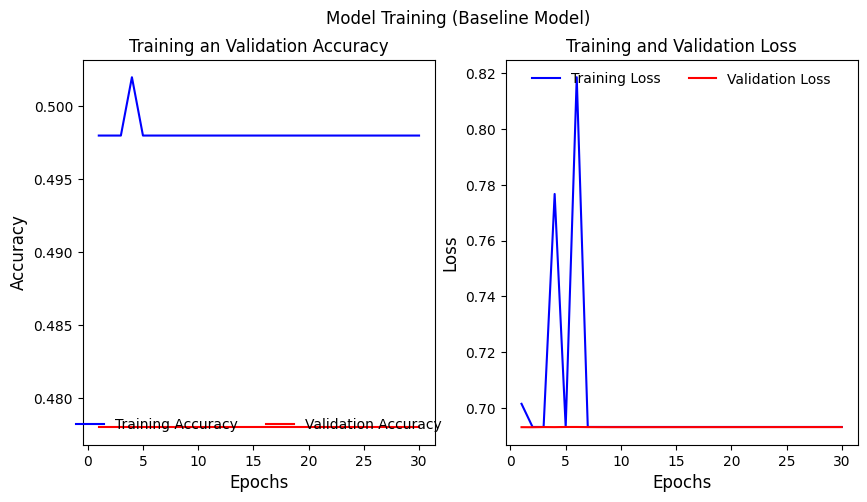

In [ ]:
# Another Plot
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
fig.suptitle("Model Training (Baseline Model)", fontsize=12)
max_epoch = len(history.history['accuracy'])+1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history.history['accuracy'], color='b', linestyle='-', label='Training Accuracy')
ax1.plot(epochs_list, history.history['val_accuracy'], color='r', linestyle='-', label='Validation Accuracy')
ax1.set_title('Training an Validation Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history.history['loss'], color='b', linestyle='-', label='Training Loss')
ax2.plot(epochs_list, history.history['val_loss'], color='r', linestyle='-', label='Validation Loss')
ax2.set_title('Training and Validation Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)

##Model performance results:##


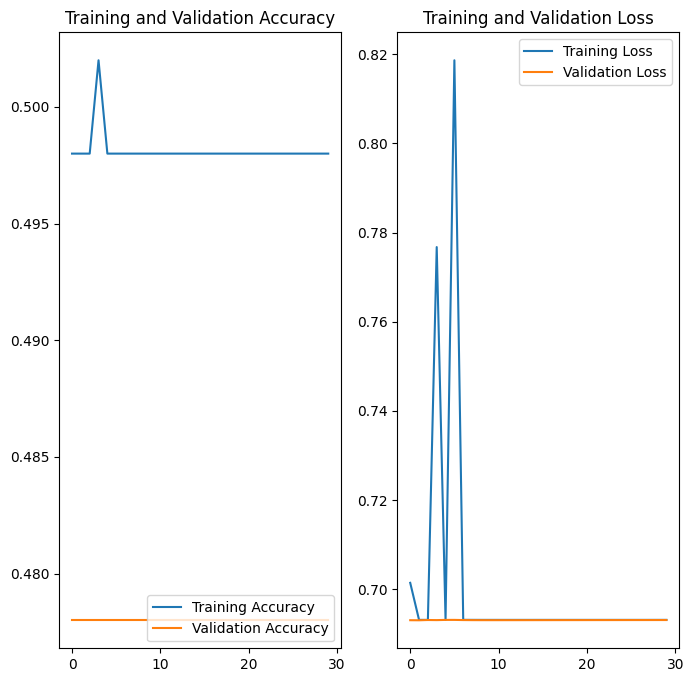

In [ ]:
plot_acuracy_loss(history)

The results showed by the plots above indicate that the model's accuracy and loss values are not improving over the epochs.

**Accuracy**: The accuracy values remain around 0.4980 throughout all epochs, indicating that the model is not learning to distinguish between classes effectively. A consistent accuracy value suggests that the model is not improving its predictive performance over the course of training.


**Loss:** Similarly, the loss values remain stable around 0.6931, indicating that the model's predictions are not improving in terms of minimizing the difference between predicted and actual values. A consistent loss value suggests that the model is not converging towards an optimal solution.

##4.2. **CNN model**
Trying to improve the accuracy and efficacy of our malaria detection model, we transition to a more sophisticated architecture leveraging Convolutional Neural Networks (CNNs). CNNs are well-suited for image classification tasks, as they can automatically learn hierarchical features from raw pixel data, leading to more robust and discriminative representations.

Is constructed using the Sequential model as the baseline model. And comprises the following layers:

**Input Layer:** Remains consistent with our previous model at (100, 100, 3), representing images with a resolution of 100x100 pixels and three color channels (RGB).

**Convolutional Layers:** The model incorporates two convolutional layers followed by max-pooling layers. The first convolutional layer has 16 filters, while the second has 32 filters, both utilizing the ReLU activation function for non-linearity.

**Max Pooling Layers:** After each convolutional layer, max-pooling layers reduce the spatial dimensions of the feature maps, enhancing computational efficiency and promoting translation invariance.

**Flatten Layer:** Similar to the baseline model.

**Dense Layers:** The model includes three dense layers with 128, 64, and 32 neurons respectively, each activated by the ReLU activation function as previous model.

**Output Layer:** As before, the final dense layer consists of a single neuron with a linear activation function, producing a continuous output interpreted as the model's accuracy score for malaria infection.

In [ ]:
cnn_model = Sequential([
  layers.Input(shape=(100, 100, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(1, activation='linear')
])

CNN model is compiled using the Adam optimizer and binary cross-entropy loss function, consistent with the previous model setup. The accuracy metric is selected to monitor the model's performance during training.

In [ ]:
cnn_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [ ]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 50, 50, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 25, 25, 32)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 20000)             0         
                                                                 
 dense_4 (Dense)             (None, 128)              

In [ ]:
epochs=20
history = cnn_model.fit(
  resized_ds_train,
  validation_data=resized_ds_val,
  epochs=epochs
)

Epoch 1/20
8/8 [==============================] - 14s 2s/step - loss: 0.7134 - accuracy: 0.4960 - val_loss: 0.6892 - val_accuracy: 0.4780
Epoch 2/20
8/8 [==============================] - 10s 1s/step - loss: 0.6867 - accuracy: 0.4980 - val_loss: 0.6821 - val_accuracy: 0.4780
Epoch 3/20
8/8 [==============================] - 10s 1s/step - loss: 0.6703 - accuracy: 0.5020 - val_loss: 0.6689 - val_accuracy: 0.4780
Epoch 4/20
8/8 [==============================] - 12s 1s/step - loss: 0.6358 - accuracy: 0.5850 - val_loss: 0.7142 - val_accuracy: 0.4800
Epoch 5/20
8/8 [==============================] - 10s 1s/step - loss: 0.6168 - accuracy: 0.6250 - val_loss: 0.6503 - val_accuracy: 0.5760
Epoch 6/20
8/8 [==============================] - 10s 1s/step - loss: 0.5734 - accuracy: 0.6620 - val_loss: 0.6218 - val_accuracy: 0.6220
Epoch 7/20
8/8 [==============================] - 9s 1s/step - loss: 0.5292 - accuracy: 0.7160 - val_loss: 0.6210 - val_accuracy: 0.6300
Epoch 8/20
8/8 [===================

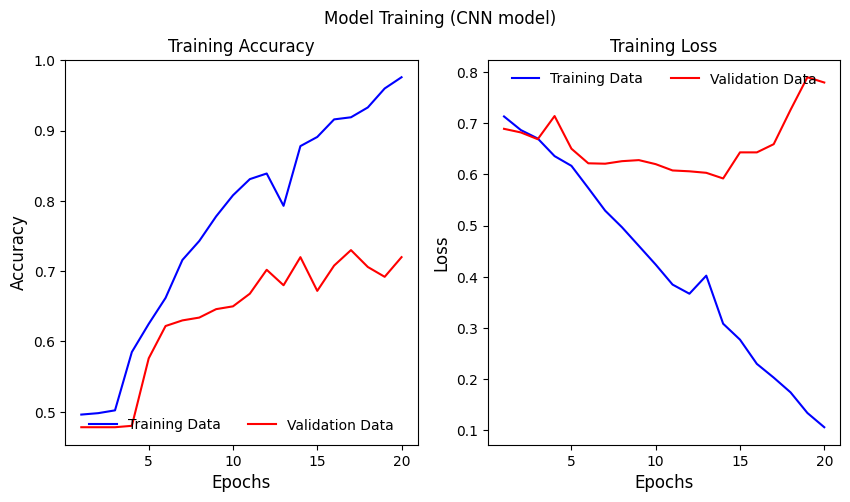

In [ ]:
# Another Plot - CNN model
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
fig.suptitle("Model Training (CNN model)", fontsize=12)
max_epoch = len(history.history['accuracy'])+1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)

##Model performance results:##

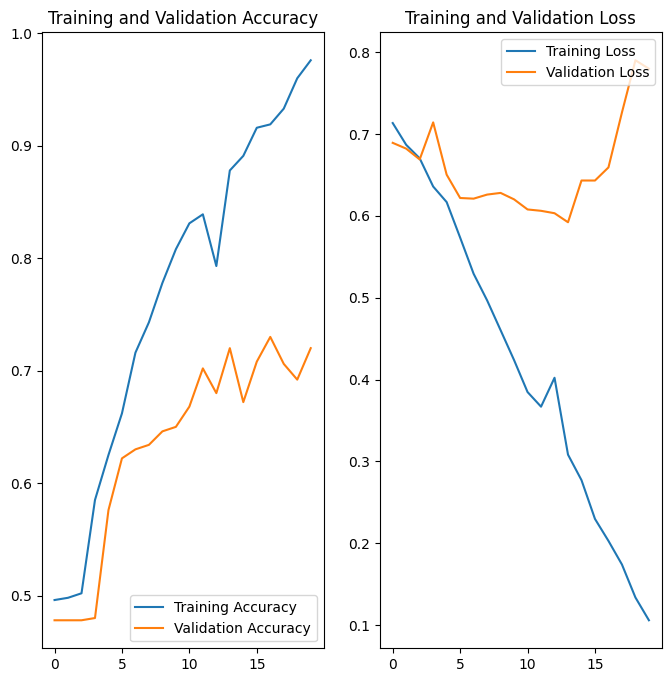

In [ ]:
plot_acuracy_loss(history)

There are noticeable improvements in both accuracy and loss values compared to the previous model (Baseline Model):

**Accuracy:** The accuracy values have increased gradually over epochs, reaching a peak of 97,60% in Epoch 15. This indicates that the model is learning to classify the images more accurately as training progresses.

**Loss:** The loss values have decreased consistently over epochs, reaching a minimum of 10,59% in Epoch 20. This diminishing loss signifies that the model's predictions are progressively closer to the true labels, indicative of improved performance and enhanced predictive capability.

**Validation Accuracy:** Similarly, the validation accuracy values have demonstrated improvement over the epochs, achieving a maximum of 72.00% in Epoch 20. This suggests that the model is generalizing well to unseen data, as it consistently performs better on validation sets.

**Overfitting Analysis:**
Overfitting occurs when a model learns to memorize the training data instead of generalizing from it. In this case, the increasing validation loss and stagnating validation accuracy after a certain point (around epoch 10) could indicate overfitting.
The fact that the training accuracy is significantly higher than the validation accuracy also supports the hypothesis of overfitting. The model seems to perform well on the training data but less so on unseen validation data.

**Model Performance:**
The final validation accuracy achieved by the model is around 72%, which means that it correctly predicts the class labels for 72% of the samples in the validation set.
Similarly, the final training accuracy is around 97.6%, indicating that the model has learned to predict the training data labels with high accuracy. However, this high training accuracy doesn't necessarily translate to good performance on unseen data.

Overall, these results suggest that the model is learning effectively from the training data and is performing better in terms of accuracy and loss compared to the previous model (Baseline Model). However, it's essential to continue monitoring the model's performance and consider further optimization strategies to achieve even better results.

#5. Model Regularization

##5.1. Regularization with dropout

Using regularization techniques such as dropout to address overfitting is a common and effective strategy in deep learning. Dropout is a regularization technique where randomly selected neurons are ignored during training. This prevents the model from relying too heavily on any individual neuron, thus reducing overfitting by promoting more robust and generalizable representations.

In [ ]:
drop_out_model = Sequential([
  layers.Input(shape=(100, 100, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.01),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.01),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.01),
  layers.Dense(64, activation='relu'),
  layers.Dropout(0.01),
  layers.Dense(32, activation='relu'),
  layers.Dropout(0.01),
  layers.Dense(1, activation='linear')
])

In [ ]:
drop_out_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [ ]:
drop_out_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 50, 50, 16)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 50, 50, 16)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 25, 25, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 25, 25, 32)       

In [ ]:
epochs=20
history = drop_out_model.fit(
  resized_ds_train,
  validation_data=resized_ds_val,
  epochs=epochs
)

Epoch 1/20
8/8 [==============================] - 13s 1s/step - loss: 0.7859 - accuracy: 0.5160 - val_loss: 0.6706 - val_accuracy: 0.4780
Epoch 2/20
8/8 [==============================] - 11s 1s/step - loss: 0.6617 - accuracy: 0.5380 - val_loss: 0.6532 - val_accuracy: 0.5620
Epoch 3/20
8/8 [==============================] - 10s 1s/step - loss: 0.6301 - accuracy: 0.6100 - val_loss: 0.6464 - val_accuracy: 0.5780
Epoch 4/20
8/8 [==============================] - 11s 1s/step - loss: 0.5972 - accuracy: 0.6490 - val_loss: 0.6855 - val_accuracy: 0.5520
Epoch 5/20
8/8 [==============================] - 13s 2s/step - loss: 0.5758 - accuracy: 0.6670 - val_loss: 0.6668 - val_accuracy: 0.5700
Epoch 6/20
8/8 [==============================] - 12s 1s/step - loss: 0.5331 - accuracy: 0.7040 - val_loss: 0.6721 - val_accuracy: 0.5760
Epoch 7/20
8/8 [==============================] - 12s 2s/step - loss: 0.4991 - accuracy: 0.7330 - val_loss: 0.6549 - val_accuracy: 0.6120
Epoch 8/20
8/8 [==================

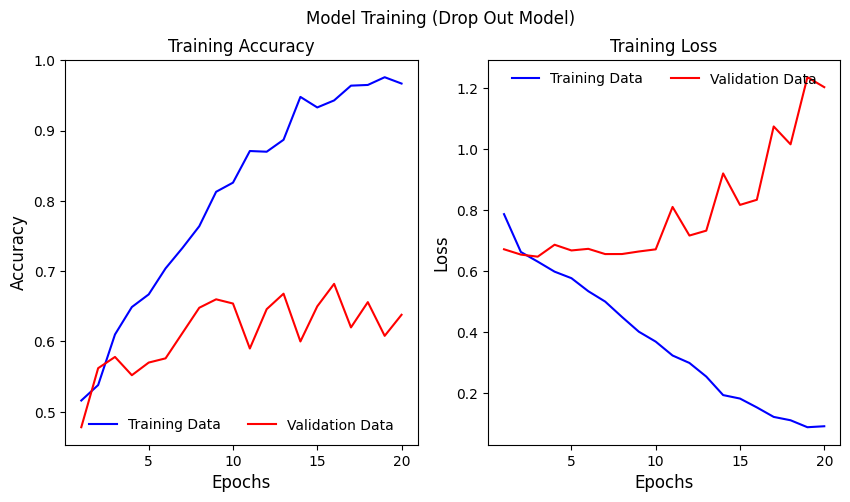

In [ ]:
# Another Plot - Drop Out Model
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
fig.suptitle("Model Training (Drop Out Model)", fontsize=12)
max_epoch = len(history.history['accuracy'])+1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)

##Regularization results:##

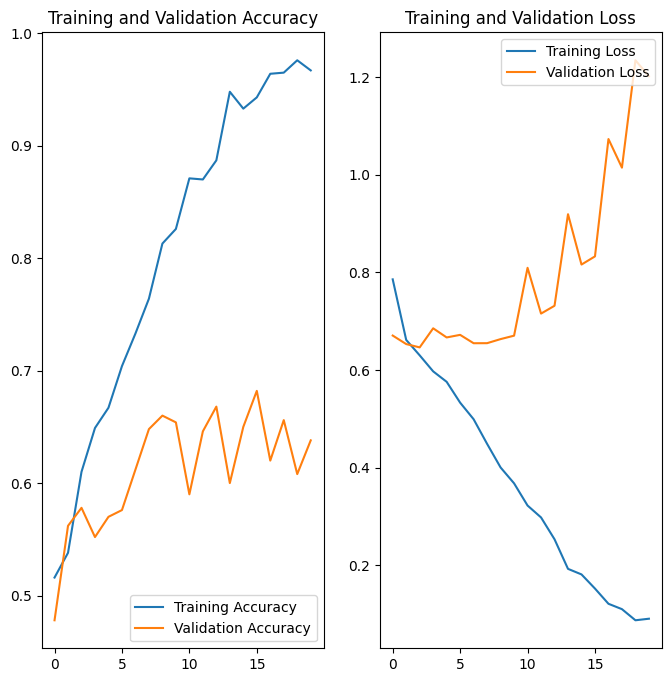

In [ ]:
plot_acuracy_loss(history)

**Accuracy:** The traning accuracy values in the current set of results exhibit fluctuations over epochs, peaking at 96.70% in Epoch 20. Althought there are noticeable variations in accuracy in the later epochs, indicating some instability in the training process.

**Loss:** Throughout the epochs, the loss values consistently decrease, showcasing the model's ability to minimize the difference between predicted and actual values. However, there is a slight increase in loss towards the end of training, which could potentially signify overfitting or instability in the model's learning process.

**Validation Accuracy:** The validation accuracy values display an upward trend, reaching a maximum of 63.80% in Epoch 20. Although this peak is lower than the validation accuracy values observed in the previous model, it still indicates an improvement over earlier epochs. This suggests that the model is generalizing better to unseen data, albeit with some room for further enhancement.

**Overfitting:**
There is a noticeable gap between training and validation performance metrics, suggesting potential overfitting. The model performs significantly better on the training data compared to the validation data, indicating that it might be memorizing the training examples rather than learning general patterns.


**In summary,** while this model (Regularization with dropout) shows some improvements over the original CNN model in terms of training loss, it falls short in terms of validation accuracy and still struggles with overfitting.
Further optimization and experimentation are needed to develop a more robust and generalizable CNN model. It's essential to continue experimenting with different regularization techniques, hyperparameters, or model architectures to address overfitting and enhance overall model performance.

##5.2. Add L2 Regularization
In an attempt to explore different regularization strategies and fine-tune the regularization strength to achieve better generalization performance and model interpretability, we decided to try the L2 Regularization model with the aim of build a more robust and reliable neural network model

In [ ]:
kernel_regularizer = tf.keras.regularizers.L2(0.01)

In [ ]:
l2_model = Sequential([
  layers.Input(shape=(100, 100, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=kernel_regularizer),
  layers.MaxPooling2D(),
  layers.Dropout(0.01),
  layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=kernel_regularizer),
  layers.MaxPooling2D(),
  layers.Dropout(0.01),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.01),
  layers.Dense(64, activation='relu'),
  layers.Dropout(0.01),
  layers.Dense(32, activation='relu'),
  layers.Dropout(0.01),
  layers.Dense(1, activation='linear')
])

In [ ]:
learning_rate = 0.001

l2_model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [ ]:
l2_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 50, 50, 16)        0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 50, 50, 16)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 50, 50, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 25, 25, 32)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 25, 25, 32)       

In [ ]:
epochs=20
history = l2_model.fit(
  resized_ds_train,
  validation_data=resized_ds_val,
  epochs=epochs
)

Epoch 1/20
8/8 [==============================] - 13s 1s/step - loss: 1.1022 - accuracy: 0.5070 - val_loss: 0.9390 - val_accuracy: 0.4780
Epoch 2/20
8/8 [==============================] - 11s 1s/step - loss: 0.9269 - accuracy: 0.4990 - val_loss: 0.9010 - val_accuracy: 0.4780
Epoch 3/20
8/8 [==============================] - 11s 1s/step - loss: 0.8797 - accuracy: 0.5270 - val_loss: 0.8677 - val_accuracy: 0.5300
Epoch 4/20
8/8 [==============================] - 13s 2s/step - loss: 0.8382 - accuracy: 0.6060 - val_loss: 0.8428 - val_accuracy: 0.5640
Epoch 5/20
8/8 [==============================] - 12s 2s/step - loss: 0.8018 - accuracy: 0.6270 - val_loss: 0.8228 - val_accuracy: 0.5320
Epoch 6/20
8/8 [==============================] - 11s 1s/step - loss: 0.7707 - accuracy: 0.6170 - val_loss: 0.8518 - val_accuracy: 0.5760
Epoch 7/20
8/8 [==============================] - 10s 1s/step - loss: 0.7417 - accuracy: 0.6690 - val_loss: 0.8194 - val_accuracy: 0.5460
Epoch 8/20
8/8 [==================

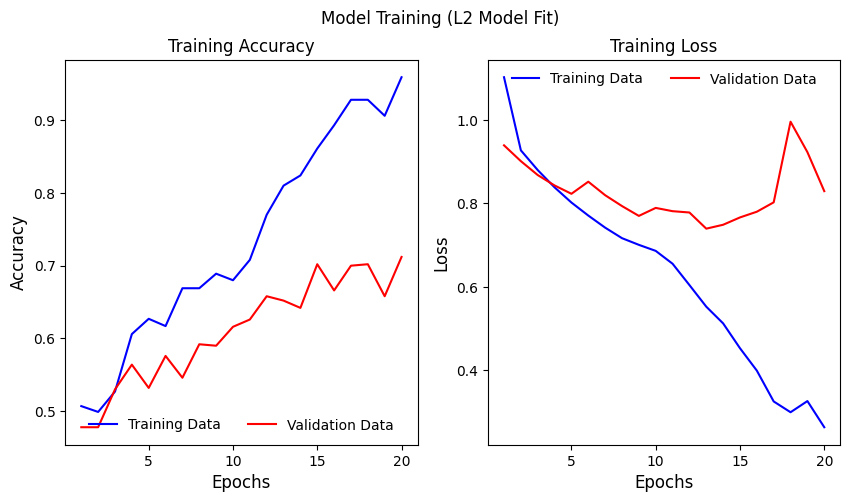

In [ ]:
# Another Plot - L2 Model Fit
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
fig.suptitle("Model Training (L2 Model Fit)", fontsize=12)
max_epoch = len(history.history['accuracy'])+1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)

##Regularization results:##

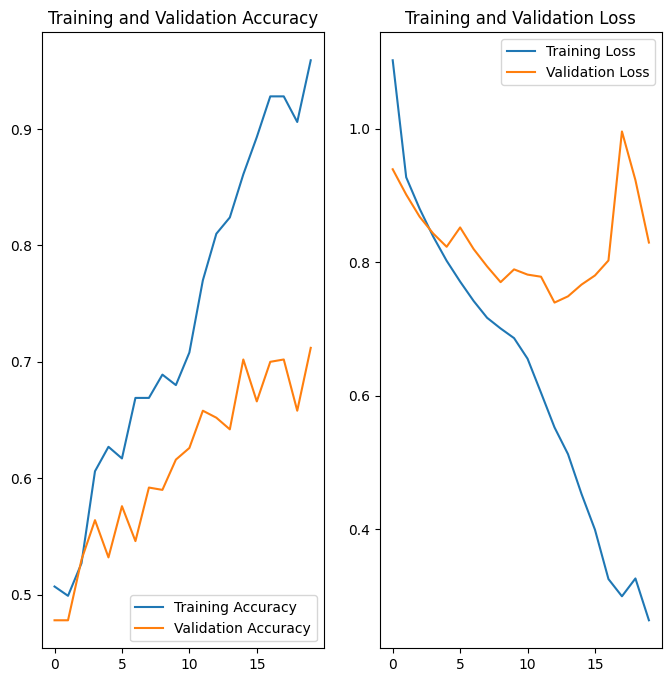

In [ ]:
plot_acuracy_loss(history)

**Accuracy:**
The accuracy values show fluctuations throughout the epochs, with the highest accuracy of 95.90% achieved in Epoch 20.

**Loss:**
The loss values exhibit a decreasing trend over the epochs, implying that the model is effectively minimizing the difference between predicted and actual values.
However, there is a slight increase in loss towards the end of training, particularly noticeable in Epochs 19 and 20. This increase could indicate overfitting or instability in the model's learning process due to the regularization applied.

**Validation Accuracy:**
The validation accuracy values show an increasing trend, reaching a maximum of 71.20% in Epoch 20.
The increasing trend in validation accuracy suggests that the regularization applied, in this case, L2 regularization, is aiding the model in generalizing better to unseen data.

**Overfitting:**
In the L2 regularization results, there are signs of overfitting, especially towards the later epochs.
Overall, the signs of overfitting in the L2 regularization results include the increasing gap between training and validation accuracy/loss, fluctuations in validation accuracy, and a slight increase in validation loss towards the end of training. To mitigate overfitting, techniques like early stopping or reducing model complexity may be employed.


**In summary**, and comparing with the CNN model both models exhibit signs of overfitting, but the CNN model generally performs better in terms of accuracy on both training and validation datasets. However, further optimization and regularization techniques may be needed to reduce overfitting and improve generalization performance.

Both the Dropout model and the L2 regularization model exhibit similar trends in terms of accuracy, loss, and validation accuracy.
However, both regularization techniques appear to be effective in improving the model's performance and preventing overfitting, as indicated by the generalization to unseen data observed in the validation accuracy results.

##5.3. Add L2 Regularization with decrease in Learning Rate to 0,0001
A common strategy to promote stable training, fine-tune model parameters, mitigate overfitting, and improve generalization performance is decreasing the learning rate from 0.001 to 0.0001 in a regularization model.This adjustment can help ensure that the model learns meaningful patterns from the data while minimizing the risk of overfitting to the training set.







In [49]:
kernel_regularizer = tf.keras.regularizers.L2(0.01)

In [50]:
l2_2_model = Sequential([
  layers.Input(shape=(100, 100, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=kernel_regularizer),
  layers.MaxPooling2D(),
  layers.Dropout(0.01),
  layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=kernel_regularizer),
  layers.MaxPooling2D(),
  layers.Dropout(0.01),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.01),
  layers.Dense(64, activation='relu'),
  layers.Dropout(0.01),
  layers.Dense(32, activation='relu'),
  layers.Dropout(0.01),
  layers.Dense(1, activation='linear')
])

In [51]:
learning_rate = 0.0001

l2_2_model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [52]:
l2_2_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 50, 50, 16)        0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 50, 50, 16)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 25, 25, 32)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 25, 25, 32)       

In [53]:
epochs=20
history = l2_2_model.fit(
  resized_ds_train,
  validation_data=resized_ds_val,
  epochs=epochs
)

Epoch 1/20
8/8 [==============================] - 14s 1s/step - loss: 0.9527 - accuracy: 0.4980 - val_loss: 0.9437 - val_accuracy: 0.4780
Epoch 2/20
8/8 [==============================] - 10s 1s/step - loss: 0.9218 - accuracy: 0.5390 - val_loss: 0.9230 - val_accuracy: 0.5420
Epoch 3/20
8/8 [==============================] - 11s 1s/step - loss: 0.8966 - accuracy: 0.5800 - val_loss: 0.9132 - val_accuracy: 0.5800
Epoch 4/20
8/8 [==============================] - 12s 1s/step - loss: 0.8751 - accuracy: 0.6140 - val_loss: 0.9063 - val_accuracy: 0.5820
Epoch 5/20
8/8 [==============================] - 10s 1s/step - loss: 0.8578 - accuracy: 0.6350 - val_loss: 0.8986 - val_accuracy: 0.5960
Epoch 6/20
8/8 [==============================] - 9s 1s/step - loss: 0.8462 - accuracy: 0.6430 - val_loss: 0.8912 - val_accuracy: 0.6020
Epoch 7/20
8/8 [==============================] - 10s 1s/step - loss: 0.8269 - accuracy: 0.6490 - val_loss: 0.8849 - val_accuracy: 0.6120
Epoch 8/20
8/8 [===================

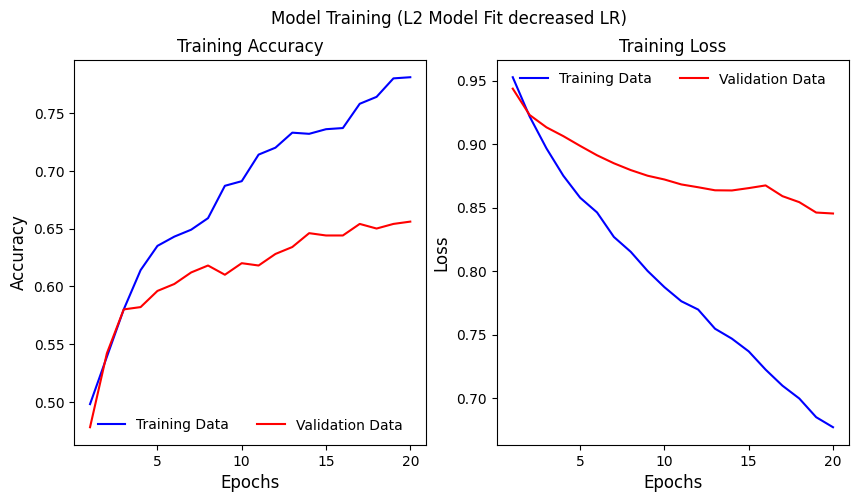

In [55]:
# Another Plot - L2 Model Fit with decreased learning rate
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
fig.suptitle("Model Training (L2 Model Fit decreased LR)", fontsize=12)
max_epoch = len(history.history['accuracy'])+1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)

**Accuracy:** The accuracy values show fluctuations throughout the epochs, with the highest accuracy of 78.10% achieved in Epoch 20. This indicates that the model's ability to correctly classify the training data varies over the training period, reaching its peak towards the end of training.

**Loss:** The loss values exhibit a decreasing trend over the epochs, implying that the model is effectively minimizing the difference between predicted and actual values.

**Validation Accuracy:** The validation accuracy values show an increasing trend, reaching a maximum of 65.60% in Epoch 20. The increasing trend in validation accuracy suggests that the regularization applied, in this case, L2 regularization with decreased learning rate (0,0001), is aiding the model in generalizing better to unseen data.

**Overfitting:**
This model shows less overfitting compared to the CNN model without regularization. The training accuracy increases gradually over epochs but remains lower than the non-regularized model, indicating that the regularization helps in generalization. However, the validation accuracy is also slightly lower, suggesting that the regularization might have hindered the model's ability to learn from the training data to some extent.

**Overall,** and comparing with the CNN model, but the CNN model with L2 regularization and a decreased learning rate (0,0001) shows slightly lower validation accuracy and less overfitting compared to the non-regularized CNN model.

#6. Next improvement adjustments

# The utility of the models created

**Improved Diagnosis Accuracy:** The primary utility of the models is their ability to accurately detect malaria infection in blood cell images. By leveraging advanced neural network architectures such as CNNs and incorporating techniques like dropout regularization, the models can learn complex patterns and features indicative of malaria infection, leading to more reliable and consistent diagnosis compared to traditional methods.

**Early Detection and Treatment:** The models enable healthcare providers to identify infected individuals earlier, facilitating timely intervention and reducing the risk of severe complications or mortality associated with the disease.

**Support for Remote Healthcare:** The models can be deployed as part of health applications, enabling remote diagnosis and monitoring of malaria cases. This is particularly valuable in rural or remote areas where access to healthcare facilities is limited, allowing patients to receive timely diagnosis and guidance from healthcare professionals even from a distance.

# Project Scalability: Ensuring Expandability



To ensure the capacity of expandability, as the models can be continually refined and adapted based on feedback, new data, and advancements in machine learning techniques, We intend to develop automated training and deployment pipelines that can be easily configured and adapted for different models and regularization techniques.
This facilitates experimentation with different model configurations and enables rapid iteration and deployment of new versions.

